In [1]:
import logging

import numpy as np
from numba import njit, prange
from stumpy import core, config

logger = logging.getLogger(__name__)

In [9]:
import dask.distributed
cli = dask.distributed.Client()

In [2]:
@njit(fastmath={"nsz", "arcp", "contract", "afn", "reassoc"}, inline="always")
def _right_mins_so_far(a):
    msf_val = np.empty(len(a), dtype=np.float64)
    msf_idx = np.empty(len(a), dtype=np.int64)
    curr_msf = np.inf
    curr_idx = 0
    for i, val in enumerate(a):
        if val < curr_msf:
            msf_val[curr_idx], msf_idx[curr_idx] = val, i
            curr_msf = val
            curr_idx += 1
    return msf_val[:curr_idx], msf_idx[:curr_idx]


@njit(fastmath={"nsz", "arcp", "contract", "afn", "reassoc"}, inline="always")
def right_mins_so_far(a, idx):
    mins, mins_idx = _right_mins_so_far(a[idx:])
    return mins, mins_idx + idx


@njit(fastmath={"nsz", "arcp", "contract", "afn", "reassoc"}, inline="always")
def left_mins_so_far(a, idx):
    mins, mins_idx = _right_mins_so_far(a[:idx+1][::-1])
    return mins, len(a[:idx+1]) - 1 - mins_idx  

In [3]:
@njit(parallel=True, fastmath=True)
def _ari(
    T_A,
    T_B,
    m,
    range_stop,
    excl_zone,
    M_T,
    Σ_T,
    QT,
    QT_first,
    μ_Q,
    σ_Q,
    k,
    ignore_trivial=True,
    range_start=0,
    SL,
    SLI,
    SR,
    SRI,
    LR,
    LRI,
    RL,
    RLI
):
    """
    A Numba JIT-compiled version of STOMP for parallel computation of the
    arbitrary range indices.

    Parameters
    ----------
    T_A : ndarray
        The time series or sequence for which to compute the matrix profile

    T_B : ndarray
        The time series or sequence that contain your query subsequences
        of interest

    m : int
        Window size

    range_stop : int
        The index value along T_B for which to stop the matrix profile
        calculation. This parameter is here for consistency with the
        distributed `stumped` algorithm.

    excl_zone : int
        The half width for the exclusion zone relative to the current
        sliding window

    M_T : ndarray
        Sliding mean of time series, `T`

    Σ_T : ndarray
        Sliding standard deviation of time series, `T`

    QT : ndarray
        Dot product between some query sequence,`Q`, and time series, `T`

    QT_first : ndarray
        QT for the first window relative to the current sliding window

    μ_Q : ndarray
        Mean of the query sequence, `Q`, relative to the current sliding window

    σ_Q : ndarray
        Standard deviation of the query sequence, `Q`, relative to the current
        sliding window

    k : int
        The total number of sliding windows to iterate over

    ignore_trivial : bool
        Set to `True` if this is a self-join. Otherwise, for AB-join, set this to
        `False`. Default is `True`.

    range_start : int
        The starting index value along T_B for which to start the matrix
        profile calculation. Default is 1.

    Returns
    -------
    out : list
        The arbitrary range indices

    Notes
    -----
    `DOI: 10.1109/ICDM.2016.0085 \
    <https://www.cs.ucr.edu/~eamonn/STOMP_GPU_final_submission_camera_ready.pdf>`__

    See Table II
    """
    QT_odd = QT.copy()
    QT_even = QT.copy()
    
    
    for i in range(range_start, range_stop):
        # Numba's prange requires incrementing a range by 1 so replace
        # `for j in range(k-1,0,-1)` with its incrementing compliment
        for rev_j in prange(1, k):
            j = k - rev_j
            # GPU Stomp Parallel Implementation with Numba
            # DOI: 10.1109/ICDM.2016.0085
            # See Figure 5
            if i % 2 == 0:
                # Even
                QT_even[j] = (
                    QT_odd[j - 1]
                    - T_A[i - 1] * T_B[j - 1]
                    + T_A[i + m - 1] * T_B[j + m - 1]
                )
            else:
                # Odd
                QT_odd[j] = (
                    QT_even[j - 1]
                    - T_A[i - 1] * T_B[j - 1]
                    + T_A[i + m - 1] * T_B[j + m - 1]
                )

        if i % 2 == 0:
            QT_even[0] = QT_first[i]
            D = core._calculate_squared_distance_profile(
                m, QT_even, μ_Q[i], σ_Q[i], M_T, Σ_T
            )
        else:
            QT_odd[0] = QT_first[i]
            D = core._calculate_squared_distance_profile(
                m, QT_odd, μ_Q[i], σ_Q[i], M_T, Σ_T
            )

        if ignore_trivial:
            core.apply_exclusion_zone(D, i, excl_zone)
        
        dists, idxs = left_mins_so_far(D, i)
        SL.append(dists), SLI.append(idxs)

        dists, idxs = right_mins_so_far(D, i)
        SR.append(dists), SRI.append(idxs)

        dists, idxs = right_mins_so_far(D, 0)
        LR.append(dists), LRI.append(idxs)

        dists, idxs = left_mins_so_far(D, len(D) - 1)
        RL.append(dists), RLI.append(idxs)
        

In [4]:
def ari(T_A, m, T_B=None, ignore_trivial=True):
    """
    Compute the arbitrary range indices

    This is a convenience wrapper around the Numba JIT-compiled parallelized
    `_ari` function which computes the arbitrary range indices according to STOMP.

    Parameters
    ----------
    T_A : ndarray
        The time series or sequence for which to compute the matrix profile

    m : int
        Window size

    T_B : ndarray
        The time series or sequence that contain your query subsequences
        of interest. Default is `None` which corresponds to a self-join.

    ignore_trivial : bool
        Set to `True` if this is a self-join. Otherwise, for AB-join, set this
        to `False`. Default is `True`.

    Returns
    -------
    out : list
        The arbitrary range indices

    Notes
    -----
    `DOI: 10.1109/ICDM.2016.0085 \
    <https://www.cs.ucr.edu/~eamonn/STOMP_GPU_final_submission_camera_ready.pdf>`__

    See Table II
    """
    if T_B is None:
        T_B = T_A
        ignore_trivial = True

    T_A, μ_Q, σ_Q = core.preprocess(T_A, m)
    T_B, M_T, Σ_T = core.preprocess(T_B, m)

    if T_A.ndim != 1:  # pragma: no cover
        raise ValueError(f"T_A is {T_A.ndim}-dimensional and must be 1-dimensional. ")

    if T_B.ndim != 1:  # pragma: no cover
        raise ValueError(f"T_B is {T_B.ndim}-dimensional and must be 1-dimensional. ")

    if ignore_trivial is False and core.are_arrays_equal(T_A, T_B):  # pragma: no cover
        logger.warning("Arrays T_A, T_B are equal, which implies a self-join.")
        logger.warning("Try setting `ignore_trivial = True`.")

    if ignore_trivial and core.are_arrays_equal(T_A, T_B) is False:  # pragma: no cover
        logger.warning("Arrays T_A, T_B are not equal, which implies an AB-join.")
        logger.warning("Try setting `ignore_trivial = False`.")

    n_A = T_A.shape[0]
    k = T_B.shape[0] - m + 1
    l = n_A - m + 1
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))  
    

    SL, SLI, SR, SRI, LR, LRI, RL, RLI = [], [], [], [], [], [], [], []
    
    start = 0
    stop = l

    D = core.mass(T_A[start : start + m], T_B, M_T, Σ_T)
    if ignore_trivial:
        core.apply_exclusion_zone(D, start, excl_zone)

    dists, idxs = left_mins_so_far(D, start)
    SL.append(dists), SLI.append(idxs)

    dists, idxs = right_mins_so_far(D, start)
    SR.append(dists), SRI.append(idxs)

    dists, idxs = right_mins_so_far(D, 0)
    LR.append(dists), LRI.append(idxs)

    dists, idxs = left_mins_so_far(D, len(D) - 1)
    RL.append(dists), RLI.append(idxs)

           
    QT = core.sliding_dot_product(T_A[start : start + m], T_B)
    QT_first = core.sliding_dot_product(T_B[:m], T_A)
    
    _ari(
        T_A,
        T_B,
        m,
        stop,
        excl_zone,
        M_T,
        Σ_T,
        QT,
        QT_first,
        μ_Q,
        σ_Q,
        k,
        ignore_trivial,
        start + 1,
        SR,
        SRI,
        SL,
        SLI,
        LR,
        LRI,
        RL,
        RLI
    )

    return SL, SR, LR, RL, SLI, SRI, LRI, RLI

In [5]:
def aried(dask_client, T_A, m, T_B=None, ignore_trivial=True):
    """
    Compute the arbitrary range indices with a distributed dask cluster

    This is a convenience wrapper around the Numba JIT-compiled parallelized
    `_ari` function which computes the arbitrary range indices according to STOMP.

    Parameters
    ----------
    dask_client : client
        A Dask Distributed client that is connected to a Dask scheduler and
        Dask workers. Setting up a Dask distributed cluster is beyond the
        scope of this library. Please refer to the Dask Distributed
        documentation.

    T_A : ndarray
        The time series or sequence for which to compute the matrix profile

    m : int
        Window size

    T_B : ndarray
        The time series or sequence that contain your query subsequences
        of interest. Default is `None` which corresponds to a self-join.

    ignore_trivial : bool
        Set to `True` if this is a self-join. Otherwise, for AB-join, set this
        to `False`. Default is `True`.

    Returns
    -------
    out : list
        The arbitrary range indices

    Notes
    -----
    `DOI: 10.1109/ICDM.2016.0085 \
    <https://www.cs.ucr.edu/~eamonn/STOMP_GPU_final_submission_camera_ready.pdf>`__

    See Table II
    """
    if T_B is None:
        T_B = T_A
        ignore_trivial = True

    T_A, μ_Q, σ_Q = core.preprocess(T_A, m)
    T_B, M_T, Σ_T = core.preprocess(T_B, m)

    if T_A.ndim != 1:  # pragma: no cover
        raise ValueError(f"T_A is {T_A.ndim}-dimensional and must be 1-dimensional. ")

    if T_B.ndim != 1:  # pragma: no cover
        raise ValueError(f"T_B is {T_B.ndim}-dimensional and must be 1-dimensional. ")

    if ignore_trivial is False and core.are_arrays_equal(T_A, T_B):  # pragma: no cover
        logger.warning("Arrays T_A, T_B are equal, which implies a self-join.")
        logger.warning("Try setting `ignore_trivial = True`.")

    if ignore_trivial and core.are_arrays_equal(T_A, T_B) is False:  # pragma: no cover
        logger.warning("Arrays T_A, T_B are not equal, which implies an AB-join.")
        logger.warning("Try setting `ignore_trivial = False`.")

    n_A = T_A.shape[0]
    k = T_B.shape[0] - m + 1
    l = n_A - m + 1
    excl_zone = int(np.ceil(m / config.STUMPY_EXCL_ZONE_DENOM))

    SL, SLI, SR, SRI, LR, LRI, RL, RLI = [], [], [], [], [], [], [], []
    
    hosts = list(dask_client.ncores().keys())
    nworkers = len(hosts)

    step = 1 + l // nworkers
    QT_futures = []
    QT_first_futures = []
    for i, start in enumerate(range(0, l, step)):
        D = core.mass(T_A[start : start + m], T_B, M_T, Σ_T)
        if ignore_trivial:
            core.apply_exclusion_zone(D, start, excl_zone)

        dists, idxs = left_mins_so_far(D, start)
        SL.append(dists), SLI.append(idxs)

        dists, idxs = right_mins_so_far(D, start)
        SR.append(dists), SRI.append(idxs)

        dists, idxs = right_mins_so_far(D, 0)
        LR.append(dists), LRI.append(idxs)

        dists, idxs = left_mins_so_far(D, len(D) - 1)
        RL.append(dists), RLI.append(idxs)

    # Scatter data to Dask cluster
    T_A_future = dask_client.scatter(T_A, broadcast=True, hash=False)
    T_B_future = dask_client.scatter(T_B, broadcast=True, hash=False)
    M_T_future = dask_client.scatter(M_T, broadcast=True, hash=False)
    Σ_T_future = dask_client.scatter(Σ_T, broadcast=True, hash=False)
    μ_Q_future = dask_client.scatter(μ_Q, broadcast=True, hash=False)
    σ_Q_future = dask_client.scatter(σ_Q, broadcast=True, hash=False)
    
    for i, start in enumerate(range(0, l, step)):
        QT = core.sliding_dot_product(T_A[start : start + m], T_B)
        QT_first = core.sliding_dot_product(T_B[:m], T_A)

        QT_future = dask_client.scatter(QT, workers=[hosts[i]])
        QT_first_future = dask_client.scatter(QT_first, workers=[hosts[i]])

        QT_futures.append(QT_future)
        QT_first_futures.append(QT_first_future)
        
    futures = []
    for i, start in enumerate(range(0, l, step)):
        stop = min(l, start + step)

        futures.append(
            dask_client.submit(
                _ari,
                T_A_future,
                T_B_future,
                m,
                stop,
                excl_zone,
                M_T_future,
                Σ_T_future,
                QT_futures[i],
                QT_first_futures[i],
                μ_Q_future,
                σ_Q_future,
                k,
                ignore_trivial,
                start + 1,
            )
        )

    results = dask_client.gather(futures)
    for i, start in enumerate(range(0, l, step)):
        stop = min(l, start + step)
        for idx in range(4):
          out_dist[idx][start + 1 : stop] = results[i][0][idx]
          out_idx[idx][start + 1 : stop] = results[i][1][idx]

    return out_dist, out_idx

In [1]:
@njit(fastmath={"nsz", "arcp", "contract", "afn", "reassoc"})
def arq(m, n, start, end, ARI, inclusive=True, absolute=True):
    """
    Query the Arbitrary Range Index to find the corresponding Matrix Profile

    Parameters
    ----------
    m : int
      Window size

    n : int
      Length of time series

    start : int
      Start index of inclusion/exclusion zone

    end : int
      End index of inclusion/exclusion zone

    ARI : [numba.typed.List] tuple
      The minimum-so-far indexes & distances

    inclusive : bool, default True
      Specify an inclusive or exclusive ('inclusive=False') zone

    absolute : bool, default True
      Specify an absolute or relative ('absolute=False') query. If true, 'start' and
      'end' refer to exact indexes of inclusion/exclusion zone. If false, 'start'/'end'
      refer to distance left/right of sliding search query.

    Returns:
    --------
      P : [float] numpy.ndarray
        The matrix profile

      I : [int] numpy.ndarray
        The matrix profile indexes
    """
    
    distances, indexes = ARI # as of right now to match output of ari function

    start = int(np.abs(start)) # in case negative is used for relative range start

    
    if absolute and inclusive:
      query_range = np.arange(start, end - m + 1)
      left_search = start
      right_search = end - m + 1
      
    if absolute and not inclusive:
      query_range = np.arange(start), np.arange(min(n - m + 1, end + 1), n - m + 1)
      query_range = np.concatenate(query_range)
      left_search = 1 - start
      right_search = end - 1
    
    if inclusive and not absolute:
      query_range = np.arange(n - m + 1)
      left_search = end + 1
      right_search = start - 1

    if not inclusive and not absolute:
      query_range = np.arrange(n - m + 1)
      left_search = end
      right_search = 0 - start

    ## to match the ARI parameter/ari function output ##  
    if inclusive:
      left_distances = distances[0]
      left_indexes = indexes[0]
      right_distances = distances[1]
      right_indexes = indexes[1]
      
    if not inclusive:
      left_distances = distances[3]
      left_indexes = indexes[3]
      right_distances = distances[2]
      right_indexes = indexes[2]
      
      
    out = np.empty((len(query_range), 2), )
    # out[:,0] is distance, out[:,1] is index a la original stumpy.stump

    
    for i, query_idx in enumerate(query_range):
      
      if not absolute:
        left_search += query_idx
        right_search += query_idx
        
      
      left_idx = binary_search_less_than(left_indexes[query_idx], left_search)
      
      if left_idx >= 0:
        left_value = left_distances[query_idx][left_idx]
      else:
        left_value = np.inf
        
      
      right_idx = binary_search_greater_than(right_indexes[query_idx], right_search)
      
      if right_idx >= 0:
        right_value = right_distances[query_idx][right_idx]
      else:
        right_value = np.inf
        
        
      if left_value < right_value:
          out[i][0] = left_value
          out[i][1] = left_indexes[query_idx][left_idx]

      elif right_value < left_value:
          out[i][0] = right_value
          out[i][1] = right_indexes[query_idx][right_idx]

      else:
          out[i][0] = np.inf
          out[i][1] = -1

      
    return out

In [6]:
@njit(fastmath={"nsz", "arcp", "contract", "afn", "reassoc"})
def binary_search_less_than(search_array, stop_index):

    left = 0
    right = len(search_array) - 1

    while left <= right:
        mid = (left + right) // 2
        if search_array[mid] < stop_index:
            right = mid - 1
        else:
            left = mid + 1

    if right >=0:
        idx = right
    else:
        idx = -1

    return idx
      
      
@njit(fastmath={"nsz", "arcp", "contract", "afn", "reassoc"})
def binary_search_greater_than(search_array, stop_index):

    left = 0
    right = len(search_array) - 1

    while left <= right:
        mid = (left + right) // 2
        if search_array[mid] > stop_index:
            right = mid - 1
        else:
            left = mid + 1

    if right >=0:
        idx = right
    else:
        idx = -1

    return idx

In [2]:
%matplotlib inline
import dask, distributed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stumpy

from itertools import chain
itr = chain.from_iterable

dclient = distributed.Client()
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

In [3]:
dfs = []
for year in ["2015", "2016", "2017"]:
    for month in ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]:
        url = f"http://www.pedestrian.melbourne.vic.gov.au/datadownload/{month}_{year}.csv"
        df = pd.read_csv(url)
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True).loc[:, ["Date", "Hour", "Collins Place (North)"]]

In [4]:
ARI_MP = ARIMP(df['Collins Place (North)'].values.astype(float), 120)

stump_MP = stumpy.stumped(dclient, df['Collins Place (North)'].values.astype(float), 120)

In [5]:
from IPython.display import Image
from functools import partial
import os
def img(x):
  p = os.getcwd()
  _img = partial(Image, width=500, embed=True)
  return _img(f'{p}/images/arimp_paper/{x}.png')

data = df['Collins Place (North)'].values.astype(float)

(True, True, True, True)

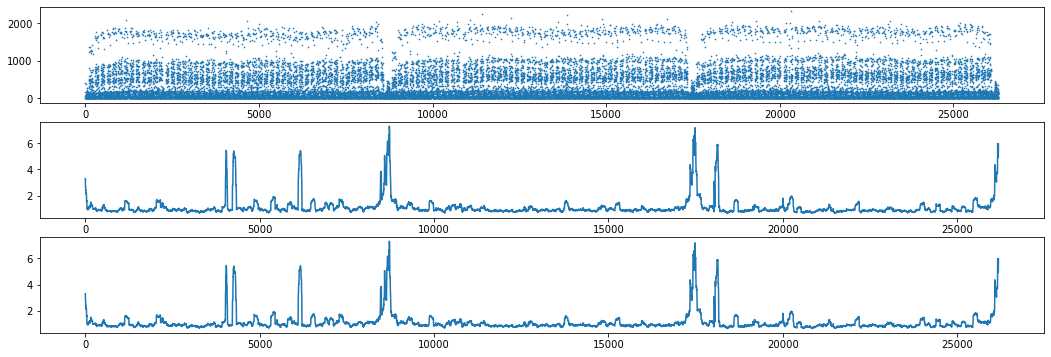

In [8]:
# Fig. 4 (11 in ext.)
# some discrepancy between paper and standard STUMP; there are three peaks in mid 2015 that the paper doesn't show. Nothing in data (holidays etc) to suggest the peaks, and rescraped the dataset with a different method and used different MP algorithms and got same results. Does not affect the ARI queries

plt.figure(42, (18,6))
plt.subplot(311)
plt.scatter(range(len(data)), data, s=.4)

plt.subplot(312)
plt.plot(stump_MP[:,0])

plt.subplot(313)
plt.plot(ARI_MP.query(0,len(data))[0])

(np.allclose(stump_MP[:,:2].astype(float).T, ARI_MP.query(0,-1, inclusive=False)), #absolute exclusive
 np.allclose(stump_MP[:,:2].astype(float).T, ARI_MP.query(0, len(data), inclusive=True)), #absolute inclusive
 np.allclose(stump_MP[:,:2].astype(float).T, ARI_MP.query(-len(data), len(data), inclusive=True, absolute=False)), #relative inclusive
 np.allclose(stump_MP[:,:2].astype(float).T, ARI_MP.query(0, 0, inclusive=False, absolute=False)) #relative exclusive
)

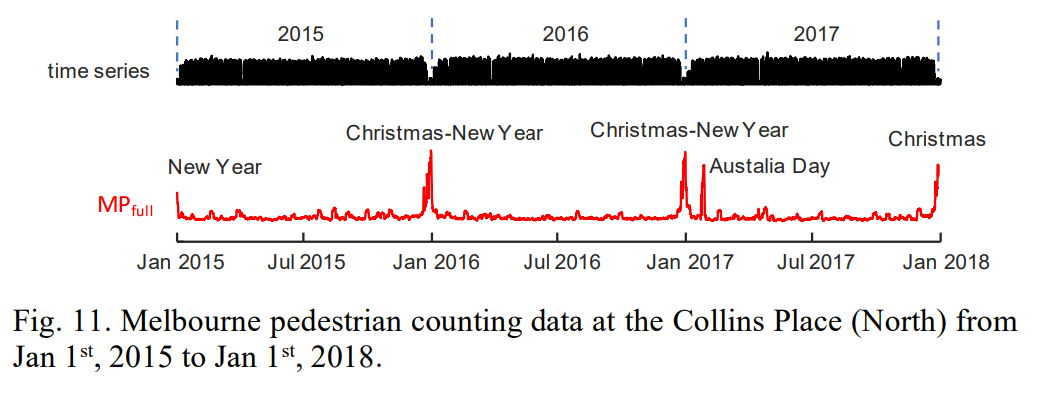

In [9]:
img('case1a')

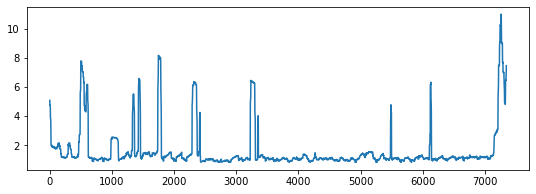

In [13]:
dates = pd.to_datetime(df.Date, dayfirst=True)

# Fig. 7 (Fig. 14 in extended paper)
months = dates[dates.dt.year==2016].groupby(dates.dt.month)
month_dist = [np.zeros(m[1].index[-1]-m[1].index[0]-120+1) for m in months]
month_idx = [x.copy() for x in month_dist]
for i, m in enumerate(months):
    mp = ARI_MP.query(m[1].index[0],m[1].index[-1])
    month_dist[i] += mp[0]
    month_idx[i] += mp[1]

plt.figure(42, (9,3))

plt.plot(list(itr(month_dist))) #ARI-MP with month-by-month inclusive queries

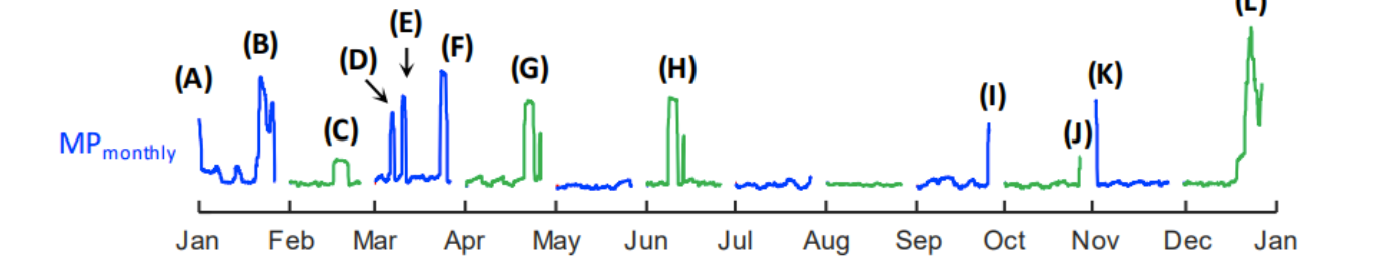

In [14]:
img('case1d')

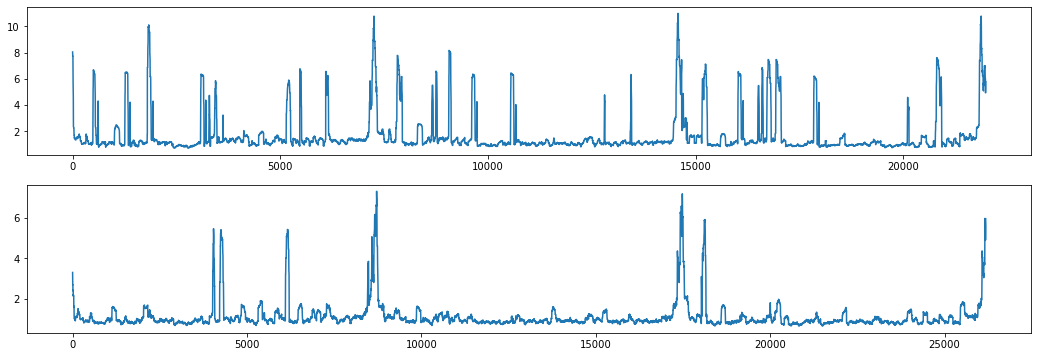

In [15]:
# Fig. 6 (Fig. 13 in ext.)
months = dates.groupby([dates.dt.year,dates.dt.month])
month_dist = [np.zeros(m[1].index[-1]-m[1].index[0]-120+1) for m in months]
month_idx = [x.copy() for x in month_dist]
for i, m in enumerate(months):
    mp = ARI_MP.query(m[1].index[0],m[1].index[-1])
    month_dist[i] += mp[0]
    month_idx[i] += mp[1]

plt.figure(42, (18,6))
plt.subplot(211)
plt.plot(list(itr(month_dist))) #ARI-MP month-by-month inclusive

plt.subplot(212)
plt.plot(stump_MP[:,0]) #standard MP

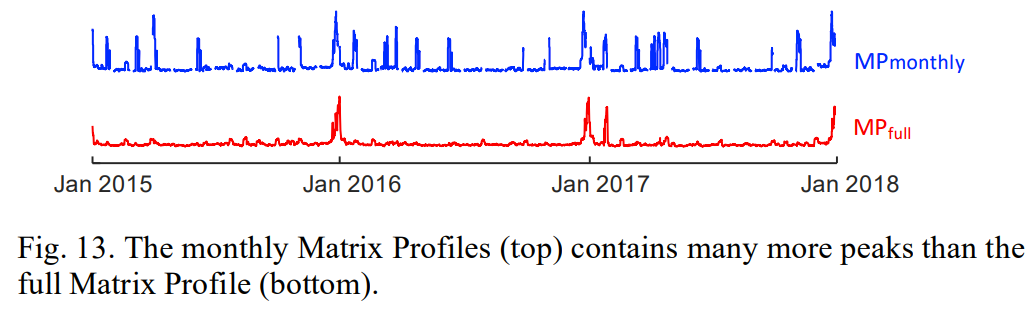

In [16]:
img('case1b')

In [29]:
# Taipei metro data (ext paper.IV.C) ... paper uses hourly data accessed in 2019 
# but the referenced link now only has datasets with daily samples...
# unable to reproduce results
# case study tests the Relative-Inclusive mode of ARI-MP

#20] Taipei Metro Ridership Data. URL: 
#https://english.metro.taipei/cp.aspx?n=C702FF0562802D53 Accessed 
#06/01/2019.


dfs2= []
for month in range(1,13):
  url = f'https://web.metro.taipei/RidershipPerStation/2016{month:02}_en.ods'
  df = pd.read_excel(url)
  df.columns = [c.strip() for c in df.columns]
  dfs2.append(df[['StationDate', 'Nanjing Fuxing']])
  
df2 = pd.concat(dfs2, ignore_index=True)

In [29]:
m = 4 # 4*24 if hourly was available
stump_MP2 = stumpy.stumped(dclient, df2['Nanjing Fuxing'].values.astype(float), m)
ARI_MP2 = ARIMP(df2['Nanjing Fuxing'].values.astype(float), m)

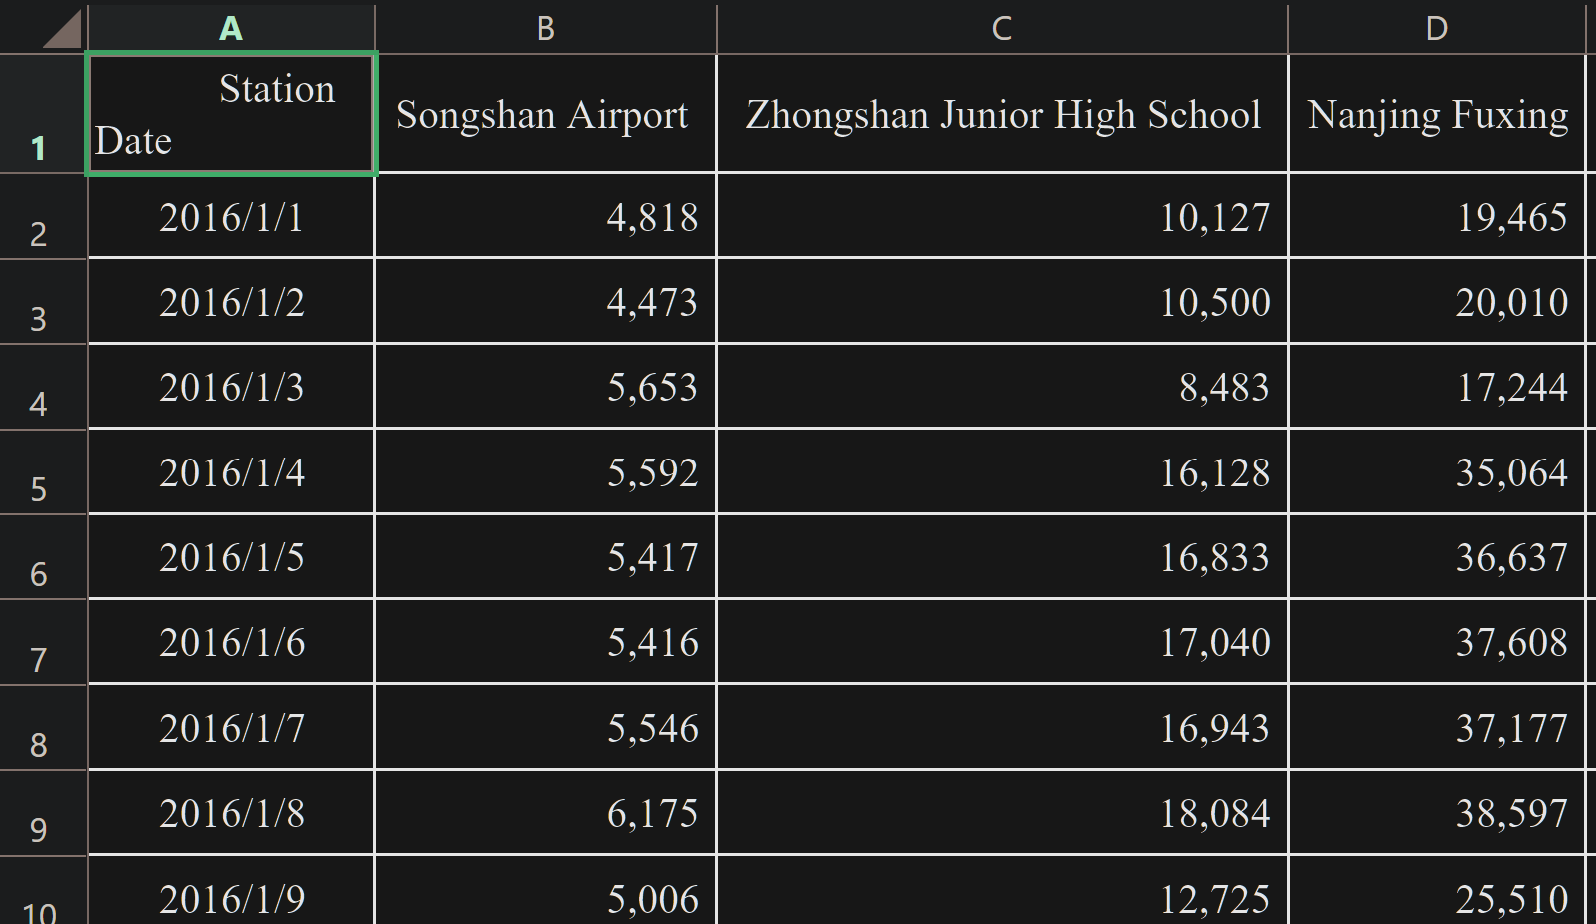

In [139]:
img('case2')

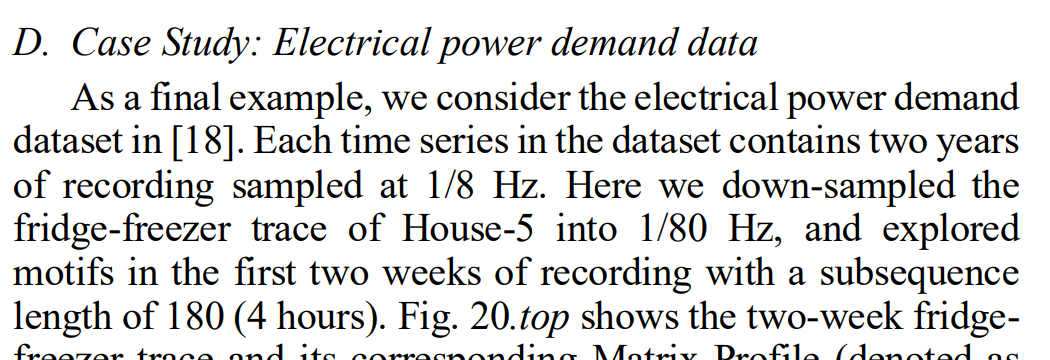

In [47]:
#final case study:

img('case3')

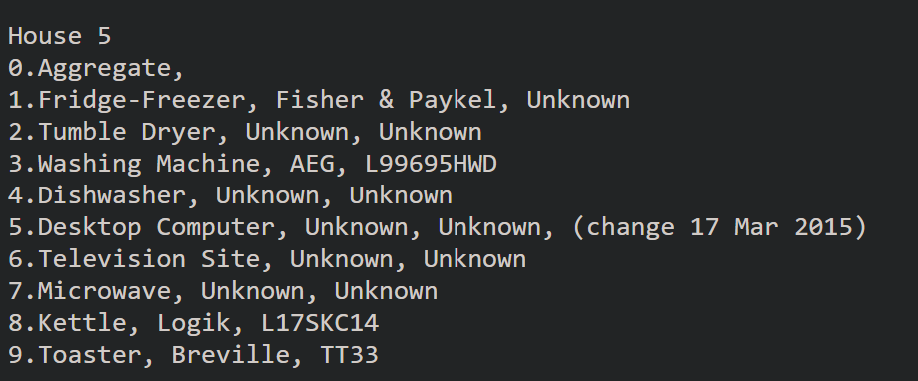

In [55]:
img('case3data')

In [106]:
# Electrical Power Demand ext paper.IV.D
# data is 500MB csv in a 500MB 7zip, so first 200,000 rows are saved
# in powerdata_raw.csv

#18] REFIT: Smart Homes and Energy Demand Reduction. URL: 
#www.refitsmarthomes.org/index.php/data. Accessed 06/01/2019.


df3 = pd.read_csv('images/arimp_paper/powerdata_raw.csv')[['Time', 'Appliance1']]
df3 = df3.set_index(pd.to_datetime(df3.Time))[:'2013-10-09'].resample('80s').mean()
values = df3.Appliance1.values

df4 = pd.read_csv('images/arimp_paper/powerdata_raw.csv')[['Time', 'Appliance1']]
df4 = df4.set_index(pd.to_datetime(df4.Time))[:'2013-10-09'].resample('80s').sum()
values2 = df4.Appliance1.values

df5 = pd.read_csv('images/arimp_paper/powerdata_raw.csv')[['Time', 'Appliance1']]
df5 = df5.iloc[ : 14*24*60*60//8 : 10]
values3 = df5.Appliance1.values

df6 = pd.read_csv('images/arimp_paper/powerdata_raw.csv')[['Time', 'Appliance1']]
values4 = df6.Appliance1.rolling(10).mean().iloc[:14*24*60*60//8:10].values

df7 = pd.read_csv('images/arimp_paper/powerdata_raw.csv')[['Time', 'Appliance1']]
values5 = df7.Appliance1.rolling(10).sum().iloc[:14*24*60*60//8:10].values

df8 = pd.read_csv('images/arimp_paper/powerdata_raw.csv')[['Time', 'Appliance1']]
df8 = df8.set_index(pd.to_datetime(df8.Time))[:'2013-10-09'].resample('80s').min()
values6 = df8.Appliance1.interpolate().values

df9 = pd.read_csv('images/arimp_paper/powerdata_raw.csv')[['Time', 'Appliance1']]
values7 = df9.Appliance1.rolling(10).min().iloc[:14*24*60*60//8:10].fillna(method='ffill').values

df10 = pd.read_csv('images/arimp_paper/powerdata_raw.csv')[['Time', 'Appliance1']]
values8 = df10.Appliance1.rolling(10).min().iloc[:14*24*60*60//8+6000:10].fillna(method='ffill').values[1:] #trial and error, adding 6000 seems closest to paper MP

In [24]:
plt.rcParams['lines.linewidth'] = 1.

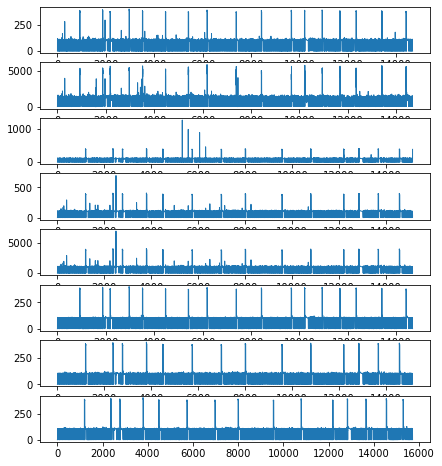

In [99]:
plt.figure(123, (7,8))
ax1 = plt.subplot(811)
ax1.plot(values)
plt.subplot(812)
plt.plot(values2)
plt.subplot(813)
plt.plot(values3)
plt.subplot(814)
plt.plot(values4)
plt.subplot(815)
plt.plot(values5)
plt.subplot(816)
plt.plot(values6)
plt.subplot(817)
plt.plot(values7)
plt.subplot(818)
plt.plot(values8)

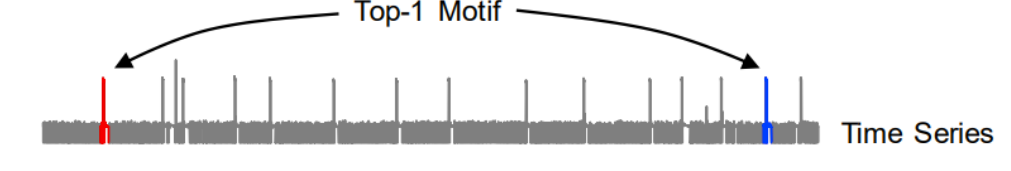

In [70]:
img('case3ser')

In [107]:
values = values8 # df10 chosen, appears closest to paper
stump3 = stumpy.stumped(dclient, values, 180)
ari3 = ARIMP(values, 180)

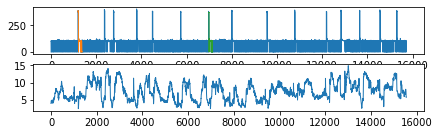

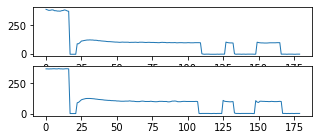

In [108]:
# Fig 20 extpaper.IV.D
# does not give same result as paper due to dataset


#these are results from stumpy.stump's standard MP


motif = np.argmin(stump3[:,0])
motif = (motif, stump3[motif,1])
plt.figure(123, (7,4))

ax1 = plt.subplot(411)
ax1.plot(values)
ax1.plot(range(motif[0],motif[0]+180), values[motif[0]:motif[0]+180])
ax1.plot(range(motif[1],motif[1]+180), values[motif[1]:motif[1]+180])

ax2 = plt.subplot(412)
ax2.plot(stump3[:,0])

fig2 = plt.figure(444, (5,2))
ax3 = plt.subplot(211)
ax3.plot(values[motif[0]:motif[0]+180])

ax4 = plt.subplot(212)
ax4.plot(values[motif[1]:motif[1]+180])

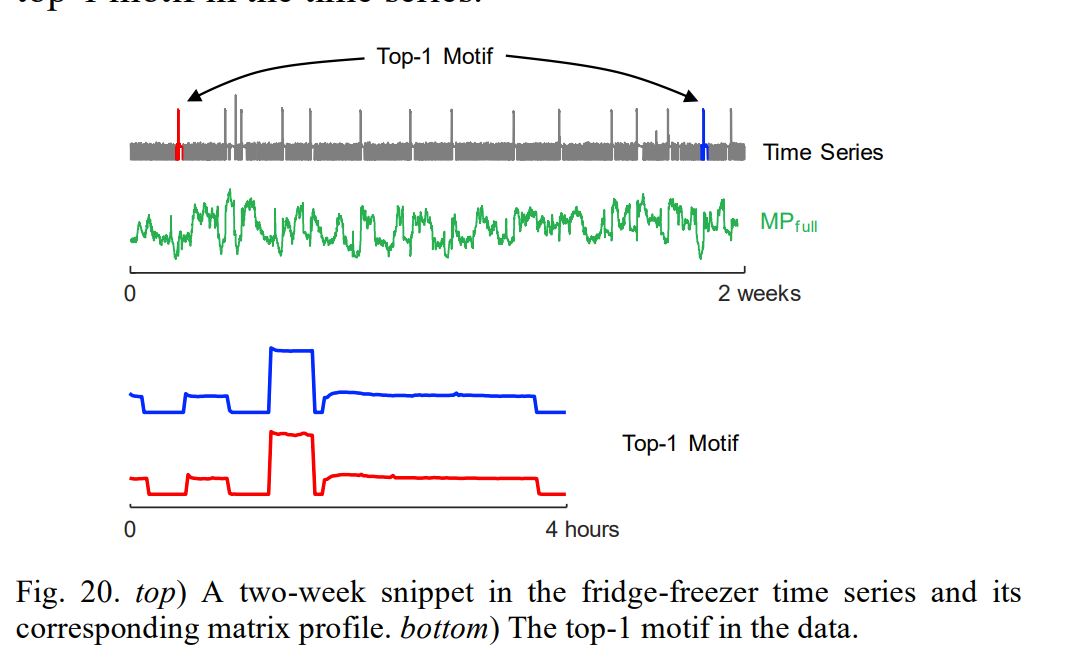

In [20]:
img('case3a')

In [112]:
# Fig 21
r = 8 * 60 * 60 / 80 #hours * minutes * seconds * Hz

mp8hr = ari3.query(r,r, absolute=False, inclusive=True)
motif = np.argmin(mp8hr[0])
motif = (motif, mp8hr[1][motif])
m1,m2 = motif[0], motif[1]

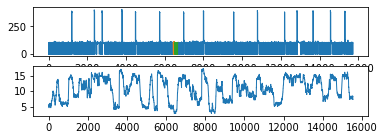

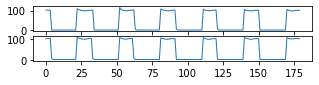

In [113]:
plt.figure(1, (6,2))
plt.subplot(211)
plt.plot(values)
plt.plot(range(m1,m1+180),values[m1:m1+180])
plt.plot(range(m2,m2+180),values[m2:m2+180])

plt.subplot(212)
plt.plot(mp8hr[0])

fig2 = plt.figure(4444, (5,1))
ax3 = plt.subplot(211)
ax3.plot(values[m1:m1+180])

ax4 = plt.subplot(212)
ax4.plot(values[m2:m2+180])

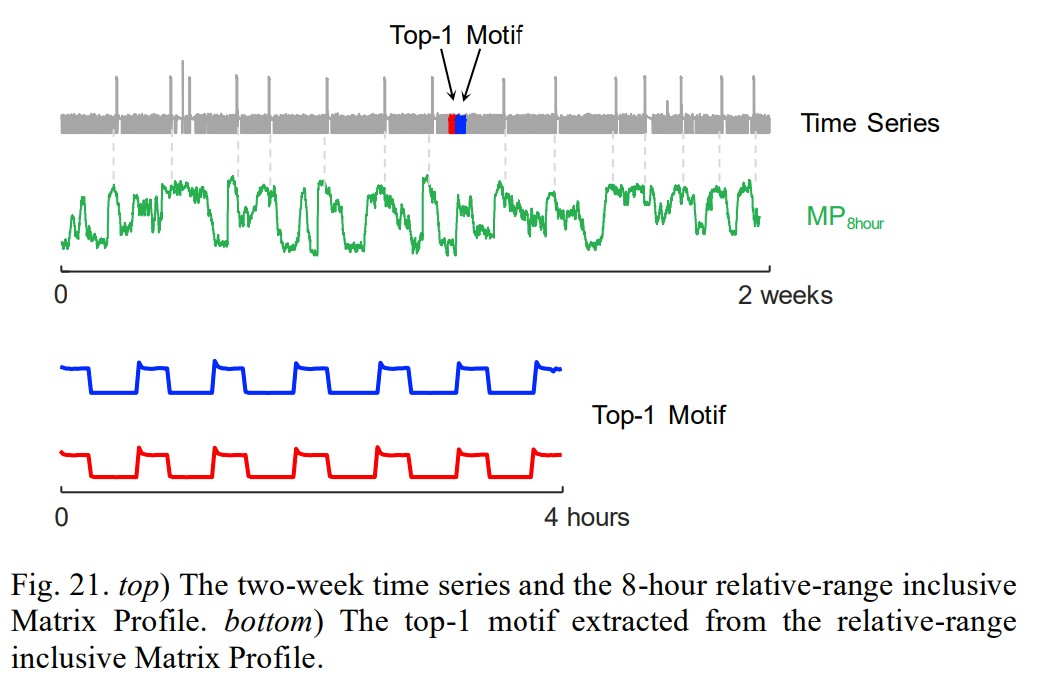

In [114]:
img('case3b')

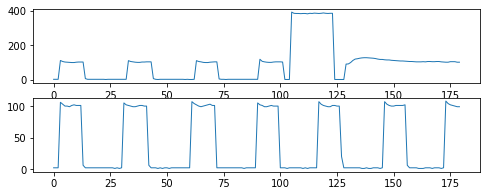

In [116]:
#fig 22

discord = mp8hr[0].argmax()
d1,d2 = discord, mp8hr[1][discord]

plt.figure(888, (8,3))
plt.subplot(211)
plt.plot(values[d1:d1+180])

plt.subplot(212)
plt.plot(values[d2:d2+180])

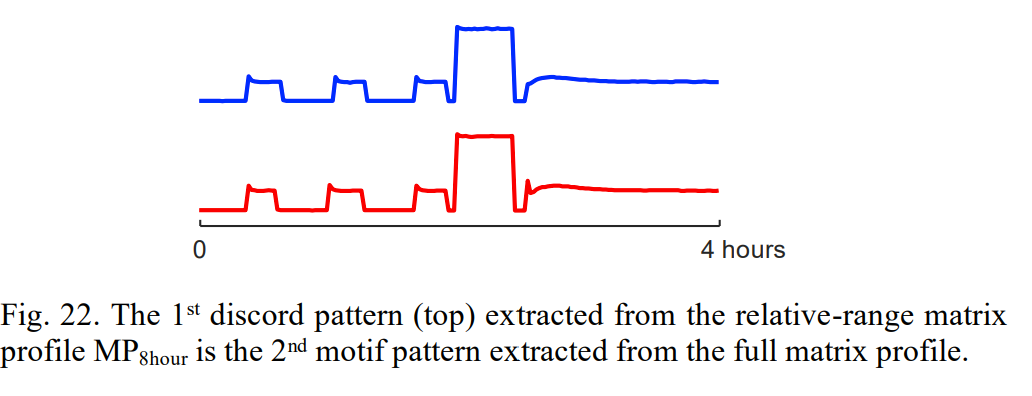

In [117]:
img('case3c')